In [1]:
from math import radians, cos, acos
import pandas as pd
from datetime import datetime, timedelta


def haversine(lon1, lat1, lon2, lat2):
    """
    :param lon1: float, 经度1
    :param lat1: float, 纬度1
    :param lon2: float, 经度2
    :param lat2: float, 纬度2
    :return: float, 地球上两点之间的距离
    """
    def hav(theta):
        return (1 - cos(theta)) / 2.0
    # 转成弧度
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    # 计算haversine
    hav_h = hav(abs(lon2 - lon1)) + cos(lon1) * cos(lon2) * hav(abs(lat2 - lat1))
    h = acos(1 - 2*hav_h)
    r = 6371  # 地球半径，6371km
    return h * r


def get_weather_station(log=-121.13333, lat=37.746753):
    """
    :param log: float, PeMS检测站经度
    :param lat: float, PeMS检测站纬度
    :return: int, 最近邻的weather检测站
    """
    df_station = pd.read_csv('../data/df_station.csv', dtype=object)
    df_station['distance'] = df_station.longitude + '_' + df_station.latitude
    df_station['distance'] = df_station['distance'].map(
        lambda x: haversine(float(x.split('_')[0]), float(x.split('_')[1]), log, lat))
    return df_station.loc[df_station.distance.idxmin()]['station_id']


def str2float(str):
    try:
        num = float(str)
    except ValueError:
        try:
            num = float(str[:-1])
        except ValueError:
            num = float('nan')
    return num


def sky2str(sky):
    try:
        tmp = sky.replace('s', '').split(' ')  # 删除字符串中的's'
    except AttributeError:  # for nan
        return float('nan')
    if '*' in tmp:  # for '*'
        return float('nan')
    elif tmp[-1].isdigit():
        # 最后一位为数字，表示云层高度
        # 取倒数第二位
        # CLR:00
        try:
            res = tmp[-2]
        except IndexError:  # for '3'
            return float('nan')
    else:
        res = tmp[-1]
    return res


def weather2code(weather, code):
    i = {'AU': 0, 'AW': 1, 'MW': 2}.get(code)
    try:
        tmp = weather.replace('s', '').split('|')[i]  # 删除字符串中的's'
    except AttributeError:  # for nan
        return float('nan')
    tmp = tmp.replace('*', '')
    if not tmp:
        return float('nan')
    return tmp.split()


def pre_date(date):
    timestamp = round((date.hour * 60 + date.minute) / 5) * 5
    hour = timestamp // 60
    minute = timestamp - hour * 60
    if hour == 24:
        date = date + timedelta(1)
        return datetime(date.year, date.month, date.day, 23, minute, 0)
    return datetime(date.year, date.month, date.day, hour, minute, 0)


def weather_dataframe(log=-121.13333, lat=37.746753):
    station_id = get_weather_station(log, lat)
    df = pd.read_csv('../data/all_weather_new.csv', dtype=object, parse_dates=['date'])
    df = df.loc[(df.station_id == station_id) & (df.date.dt.year == 2016)].reset_index(drop=True)
    # 温度
    df['temp'] = df['temp'].apply(str2float).fillna(method='ffill')
    # 能见度
    df['visibility'] = df['visibility'].apply(str2float).fillna(method='ffill')
    # 风速
    df['wind_speed'] = df['wind_speed'].apply(str2float).fillna(method='ffill')
    # 风向
    df['wind_dir'] = df['wind_dir'].apply(str2float).fillna(method='ffill')
    # 降雨量
    df['precip'] = df['precip'].apply(str2float)  # 缺失太多，不直接填充
    # 云层情况
    # 'CLR:00', 'FEW:02', 'SCT:04', 'BKN:07', 'OVC:08', 'VV:09', 'X:10'
    df['sky'] = df['sky'].apply(sky2str).fillna(method='ffill')
    # 天气类型
    df['AU'] = df['weather'].apply(weather2code, code='AU')
    df['AW'] = df['weather'].apply(weather2code, code='AW')
    df['MW'] = df['weather'].apply(weather2code, code='MW')
    del df['weather']
    # date
    df['datetime'] = df['date'].apply(pre_date)
    return df.drop_duplicates('datetime')

In [2]:
from numpy.random import seed
seed(1717)
from tensorflow import set_random_seed
set_random_seed(1717)

c:\users\zydar\anaconda3\envs\tf\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler

from keras.layers.recurrent import LSTM
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout

Using TensorFlow backend.


In [3]:
df = pd.read_csv('./data/SR99_VDS1005210_2016_fill.csv', delimiter=';', parse_dates=True, index_col='datetime')
interval = 5
timesteps = 50
epochs = 5
batch_size = int(60 / interval * 24 * 7)  # 每批处理一周数据

In [4]:
def series2supervised(data, timesteps=20, size=(1, 2)):
    assert isinstance(size[0], int) & isinstance(size[1], int), 'size[0] size[1] must be integer'
    assert size[0] <= size[1], 'size[1] not less than size[0]'
    start = '2016-%02d' % size[0]
    end = '2016-%02d' % size[1]
    value = data[start: end].copy().values
    result = []
    for index in range(len(value) - timesteps):
        result.append(value[index: index + timesteps + 1])
    result = np.array(result)
    x = result[:, :-1]
    y = result[:, -1]
    x = np.reshape(x, (x.shape[0], x.shape[1], 1))
    return x, y


def multi_series2supervised(data, timesteps=20, size=(1, 2), dropnan=True, year=2016):
    """
    :param data: DataFrame, data.index.dtype=datetime64, first columns is flow
    :param timesteps: int
    :param size: tuple, (start_month, end_month)
    :param dropnan: bool
    :param year: int
    :return: x.shape=(sample, timesteps, feature), y.shape=(sample, flow)
    """
    assert isinstance(size[0], int) & isinstance(size[1], int), 'size[0] size[1] must be integer'
    assert size[0] <= size[1], 'size[1] not less than size[0]'
    start = '%d-%02d' % (year, size[0])
    end = '%d-%02d' % (year, size[1])
    df = data[start: end].copy()
    old_names = df.columns
    n_vars = len(old_names)
    cols, names = list(), list()
    for i in range(timesteps, 0, -1):
        cols.append(df.shift(i))
        names += [('%s(t-%d)' % (old_names[j], i)) for j in range(n_vars)]
    cols.append(df[old_names[0]])
    names.append(old_names[0])
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    if dropnan:
        agg.dropna(inplace=True)
    x = agg.values[:, :-1]
    x = x.reshape(x.shape[0], timesteps, n_vars)
    y = agg.values[:, -1]
    return x, y

In [5]:
train = df[: '2016-10'].copy()
test = df['2016-11':].copy()
scaler = StandardScaler()
train['flow_scaler'] = scaler.fit_transform(train['flow_5'].values[:, np.newaxis])
test['flow_scaler'] = scaler.transform(test['flow_5'].values[:, np.newaxis])
x_train, y_train = series2supervised(train['flow_scaler'], timesteps=timesteps, size=(1, 8))
x_valid, y_valid = series2supervised(train['flow_scaler'], timesteps=timesteps, size=(9, 10))
x_test, y_test = series2supervised(test['flow_scaler'], timesteps=timesteps, size=(11, 12))

In [6]:
model = Sequential()
model.add(LSTM(32, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(Dense(1, activation='linear'))
model.compile(loss='mae', optimizer='adam')
history = model.fit(x_train, y_train, validation_data=(x_valid, y_valid), epochs=epochs, batch_size=batch_size, verbose=1)

Train on 70222 samples, validate on 17518 samples
Epoch 1/5
70222/70222 [==============================] - 7s 96us/step - loss: 0.4018 - val_loss: 0.2201
Epoch 2/5
70222/70222 [==============================] - 3s 36us/step - loss: 0.1959 - val_loss: 0.1768
Epoch 3/5
70222/70222 [==============================] - 2s 35us/step - loss: 0.1642 - val_loss: 0.1619
Epoch 4/5
70222/70222 [==============================] - 3s 36us/step - loss: 0.1580 - val_loss: 0.1590
Epoch 5/5
70222/70222 [==============================] - 3s 36us/step - loss: 0.1563 - val_loss: 0.1577


In [7]:
def print_error(y_true, y_predict):
    print('MSE: %.3f' % mse(y_true, y_predict))
    print('RMSE: %.3f' % rmse(y_true, y_predict))
    print('MAE: %.3f' % mae(y_true, y_predict))
    print('MAPE: %.3f%%' % mape(y_true, y_predict))


def plot_results(true_data, predicted_data):
    fig = plt.figure(facecolor='white')
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='True Data')
    plt.plot(predicted_data, label='Prediction')
    plt.legend()
    # plt.savefig('../res/predict.svg', format='svg')
    plt.show()

def mse(y_true, y_predict):
    # Mean Square Error
    assert len(y_true) == len(y_predict)
    return np.square(np.mean((y_true - y_predict) ** 2))


def rmse(y_true, y_predict):
    # Root Mean Square Error
    assert len(y_true) == len(y_predict)
    return np.mean((y_true - y_predict) ** 2)

def mae(y_true, y_predict):
    # Mean Absolute Error
    assert len(y_true) == len(y_predict)
    return np.mean(np.abs(y_true - y_predict))


def mape(y_true, y_predict):
    # Mean Absolute Percentage Error
    assert len(y_true) == len(y_predict)
    return np.mean(np.abs(y_true - y_predict)/np.abs(y_true)) * 100

MSE: 515717.622
RMSE: 718.135
MAE: 19.341
MAPE: 10.072%


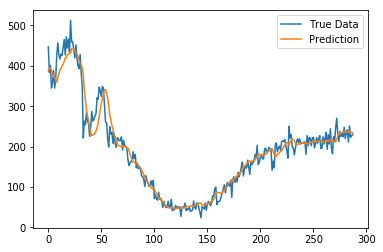

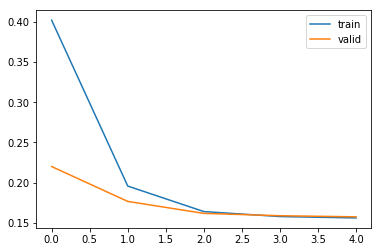

In [8]:
# predict
predict = model.predict(x_test)
predict = scaler.inverse_transform(predict).flatten()
expect = scaler.inverse_transform(y_test).flatten()
print_error(expect, predict)
plot_results(expect[1000:1288], predict[1000:1288])
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='valid')
plt.legend()
plt.show()

In [64]:
train = df[: '2016-10'].copy()
test = df['2016-11':].copy()
scaler = StandardScaler()
train['flow_scaler'] = scaler.fit_transform(train['flow_5'].values[:, np.newaxis])
test['flow_scaler'] = scaler.transform(test['flow_5'].values[:, np.newaxis])
x_train, y_train = multi_series2supervised(train[['flow_scaler']], timesteps=timesteps, size=(1, 8))
x_valid, y_valid = multi_series2supervised(train[['flow_scaler']], timesteps=timesteps, size=(9, 10))
x_test, y_test = multi_series2supervised(test[['flow_scaler']], timesteps=timesteps, size=(11, 12))

In [90]:
model = Sequential()
model.add(LSTM(32, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(Dense(1, activation='linear'))
model.compile(loss='mae', optimizer='adam')
history = model.fit(x_train, y_train, validation_data=(x_valid, y_valid), epochs=epochs, batch_size=batch_size, verbose=2)

Train on 70222 samples, validate on 17518 samples
Epoch 1/5
 - 4s - loss: 0.4352 - val_loss: 0.2306
Epoch 2/5
 - 2s - loss: 0.1971 - val_loss: 0.1830
Epoch 3/5
 - 2s - loss: 0.1700 - val_loss: 0.1647
Epoch 4/5
 - 2s - loss: 0.1598 - val_loss: 0.1602
Epoch 5/5
 - 2s - loss: 0.1571 - val_loss: 0.1588


MSE: 517396.487
RMSE: 719.303
MAE: 19.342
MAPE: 10.122%


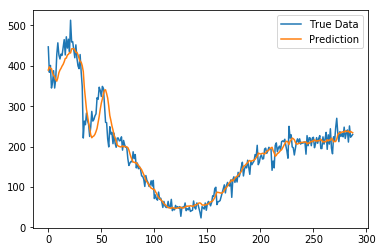

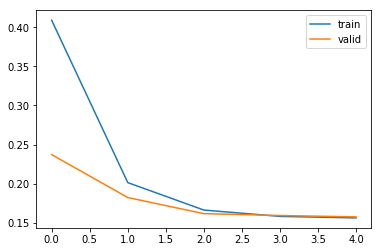

In [66]:
# predict
predict = model.predict(x_test)
predict = scaler.inverse_transform(predict).flatten()
expect = scaler.inverse_transform(y_test).flatten()
print_error(expect, predict)
plot_results(expect[1000:1288], predict[1000:1288])
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='valid')
plt.legend()
plt.show()

In [79]:
x_test, y_test = series2supervised(test['flow_scaler'], timesteps=timesteps, size=(11, 12))
x_test1, y_test1 = multi_series2supervised(test[['flow_scaler']], timesteps=timesteps, size=(11, 12))

In [88]:
(x_test.flatten() == x_test1.flatten()).sum() == len(x_test.flatten())

True

In [5]:
df_pems = pd.read_csv('./data/SR99_VDS1005210_2016_fill.csv', delimiter=';', parse_dates=True, index_col='datetime')
df_weather = weather_dataframe()
df_weather = df_weather[['datetime', 'temp', 'visibility']].set_index('datetime')
df = pd.merge(df_pems, df_weather, left_index=True, right_index=True, how='outer').fillna(method='ffill').fillna(method='bfill')

interval = 5
timesteps = 1
epochs = 1
batch_size = int(60 / interval * 24 * 7)  # 每批处理一周数据

train = df[: '2016-10'].copy()
test = df['2016-11': '2016-12'].copy()
col_names = test.columns
scaler = StandardScaler()
scaled_train = scaler.fit_transform(train.values)
scaled_test = scaler.transform(test.values)
for i in range(len(col_names)):
    train[col_names[i]] = scaled_train[:, i]
    test[col_names[i]] = scaled_test[:, i]

x_train, y_train = multi_series2supervised(train, timesteps=timesteps, size=(1, 8))
x_valid, y_valid = multi_series2supervised(train, timesteps=timesteps, size=(9, 10))
x_test, y_test = multi_series2supervised(test, timesteps=timesteps, size=(11, 12))

model = Sequential()
model.add(LSTM(32, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(Dense(1, activation='linear'))
model.compile(loss='mae', optimizer='adam')
history = model.fit(x_train, y_train, validation_data=(x_valid, y_valid),
                    epochs=epochs, batch_size=batch_size, verbose=2)

Train on 70271 samples, validate on 17567 samples
Epoch 1/1
 - 7s - loss: 0.8227 - val_loss: 0.7718


In [6]:
predict = model.predict(x_test)

In [19]:
predict.shape[0]

17567

In [26]:
y_test

array([-1.54760585, -1.48208886, -1.51484735, ..., -1.52303698,
       -1.5639851 , -1.71139834])

In [34]:
y_test[:, ]

array([-1.54760585, -1.48208886, -1.51484735, ..., -1.52303698,
       -1.5639851 , -1.71139834])

In [24]:
zero_col = np.zeros((predict.shape[0],2), dtype='float32')

In [33]:
scaler.inverse_transform(np.concatenate((predict, zero_col), axis=1))[:, 0]

array([219.0539 , 219.69177, 220.7149 , ..., 223.12181, 223.89165,
       223.34193], dtype=float32)

In [32]:
scaler.inverse_transform(np.concatenate((y_test[:, np.newaxis], zero_col), axis=1))[:, 0]

array([49., 57., 53., ..., 52., 47., 29.])

In [31]:
test1 = df['2016-11': '2016-12'].copy()
test1

,flow_5,temp,visibility
datetime,,,
2016-11-01 00:00:00,44.0,14.4,10.0
2016-11-01 00:05:00,49.0,14.4,10.0
2016-11-01 00:10:00,57.0,14.4,10.0
2016-11-01 00:15:00,53.0,14.4,10.0
2016-11-01 00:20:00,82.0,14.4,10.0
2016-11-01 00:25:00,52.0,14.4,10.0
2016-11-01 00:30:00,44.0,14.4,10.0
2016-11-01 00:35:00,44.0,14.4,10.0
2016-11-01 00:40:00,56.0,14.4,10.0
